<a href="https://colab.research.google.com/github/mahaasa/classification/blob/main/Regularization_all_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import


In [24]:
try:
    from IPython.display import clear_output
    from catboost import CatBoostClassifier
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "catboost", "-q"])
    from catboost import CatBoostClassifier

clear_output()


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.ensemble import VotingClassifier,  RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM, Dense, Dropout,Reshape, Flatten, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D, Embedding, Add, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.calibration import calibration_curve
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# preprocessing

In [26]:
dataset= pd.read_csv('star_classification.csv')
# هنگام تغییربه یک سوم نام متغییر مقصد بالا را تغییر بدهم
# 2. انتخاب یک سوم داده‌ها به صورت تصادفی
#dataset = dataset_all.sample(frac=1/3, random_state=42)
label_encoders = {}
for column in dataset.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    dataset[column] = le.fit_transform(dataset[column])
    label_encoders[column] = le

X = dataset.drop('class', axis=1)
y = dataset['class']

# 2. تقسیم داده‌ها به مجموعه‌های آموزش و تست
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# 3. مقیاس‌دهی به داده‌ها
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [27]:
results = []


# Random Forest

In [28]:
 # آموزش مدل Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=16,
                                  min_samples_split=2,
                                  min_samples_leaf=4, max_features='sqrt',
                                  criterion='entropy', random_state=42)
rf_model.fit(X_train_scaled, y_train)


RandomForestClassifier(criterion='entropy', max_depth=16, min_samples_leaf=4,
                       random_state=42)

In [29]:
# پیش‌بینی
y_pred_rf = rf_model.predict(X_test_scaled)
rf_predictions = rf_model.predict_proba(X_test_scaled)[:, 1]

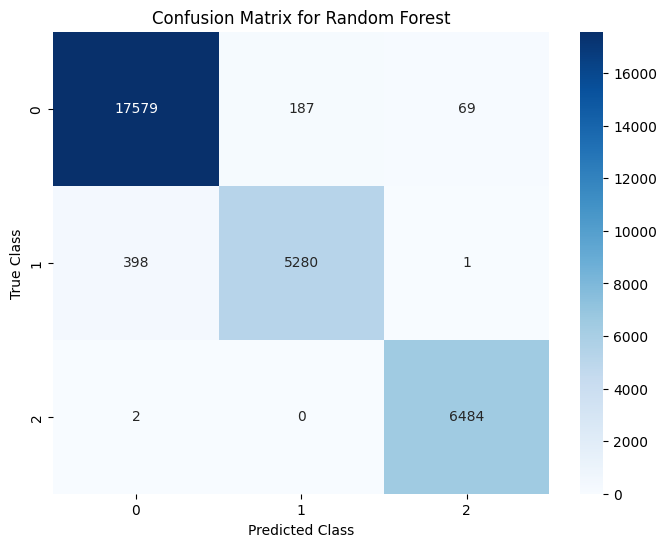

In [30]:
# محاسبه ماتریس کانفیوژن
matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_rf, annot=True, cmap='Blues', fmt='g')
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix for Random Forest")
plt.show()

In [31]:
# محاسبه متریک‌ها
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
precision_rf = precision_score(y_test, y_pred_rf, average='macro')
recall_rf = recall_score(y_test, y_pred_rf, average='macro')
sensitivity_rf = recall_rf
tn_rf = matrix_rf.sum() - matrix_rf.sum(axis=1) - matrix_rf.sum(axis=0) + np.diag(matrix_rf)
fp_rf = matrix_rf.sum(axis=0) - np.diag(matrix_rf)
specificity_rf = np.mean(tn_rf / (tn_rf + fp_rf))

results.append({
        'Model':rf_model,
        'Accuracy':accuracy_rf,
        'f1-score': f1_rf,
        'Precision': precision_rf,
        'Sensitivity': sensitivity_rf,
        'Specificity': specificity_rf
    })


print(f"Accuracy: {accuracy_rf}")
print(f"F1-score: {f1_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall (Sensitivity): {sensitivity_rf}")
print(f"Specificity: {specificity_rf}")

Accuracy: 0.9781
F1-score: 0.9745289178369926
Precision: 0.9776220299078476
Recall (Sensitivity): 0.9716929988135767
Specificity: 0.9854843349694828


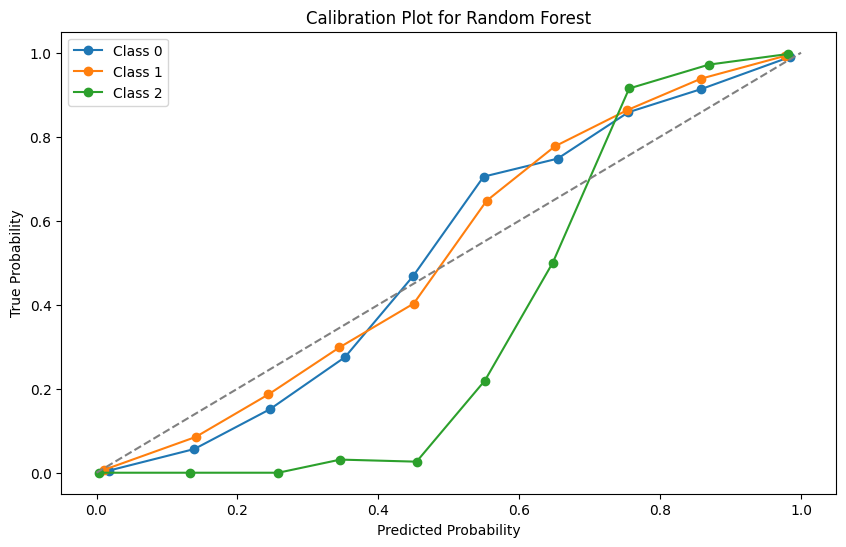

In [32]:
# کالیبراسیون
plt.figure(figsize=(10, 6))
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))
for i in range(n_classes):
    y_prob = rf_model.predict_proba(X_test_scaled)[:, i]
    y_prob = np.clip(y_prob, 0, 1)
    prob_true, prob_pred = calibration_curve(y_test_binarized[:, i], y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {i}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Plot for Random Forest')
plt.legend(loc="upper left")
plt.show()

# catBoost

In [34]:
# آموزش مدل CatBoost
cat_model = CatBoostClassifier(iterations=1000, learning_rate=0.03, logging_level='Silent')
cat_model.fit(X_train_scaled, y_train)

In [35]:
# پیش‌بینی
y_pred_cat = cat_model.predict(X_test_scaled)
y_score = cat_model.predict_proba(X_test_scaled)
catboost_predictions = cat_model.predict_proba(X_test_scaled)[:, 1]

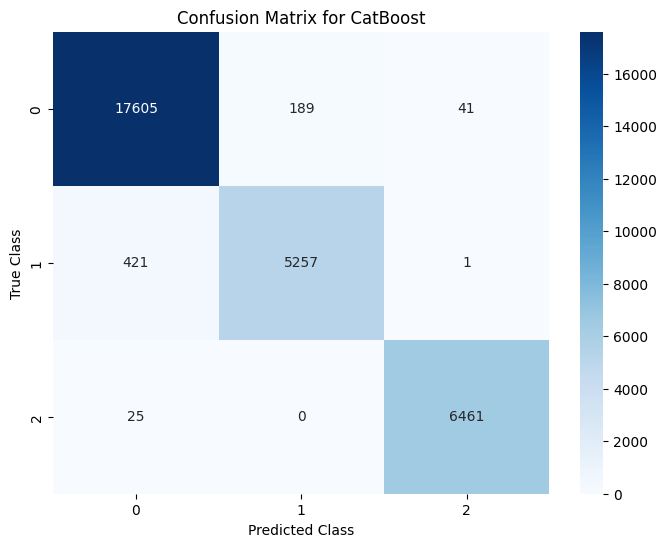

In [36]:
# ماتریس کانفیوژن
matrix_cat = confusion_matrix(y_test, y_pred_cat)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_cat, annot=True, cmap='Blues', fmt='g')
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix for CatBoost")
plt.show()

In [37]:
# محاسبه متریک‌ها
accuracy_cat = accuracy_score(y_test, y_pred_cat)
f1_cat = f1_score(y_test, y_pred_cat, average='macro')
precision_cat = precision_score(y_test, y_pred_cat, average='macro')
recall_cat = recall_score(y_test, y_pred_cat, average='macro')
sensitivity_cat = recall_cat
tn_cat = matrix_cat.sum() - matrix_cat.sum(axis=1) - matrix_cat.sum(axis=0) + np.diag(matrix_cat)
fp_cat = matrix_cat.sum(axis=0) - np.diag(matrix_cat)
specificity_cat = np.mean(tn_cat / (tn_cat + fp_cat))

results.append({
        'Model':cat_model,
        'Accuracy':accuracy_cat,
        'f1-score': f1_cat,
        'Precision': precision_cat,
        'Sensitivity': sensitivity_cat,
        'Specificity': specificity_cat
    })

print(f"Accuracy: {accuracy_cat}")
print(f"F1-score: {f1_cat}")
print(f"Precision: {precision_cat}")
print(f"Recall (Sensitivity): {sensitivity_cat}")
print(f"Specificity: {specificity_cat}")

Accuracy: 0.9774333333333334
F1-score: 0.9736943370844485
Precision: 0.978043099936222
Recall (Sensitivity): 0.9696468986757028
Specificity: 0.9845934038329837


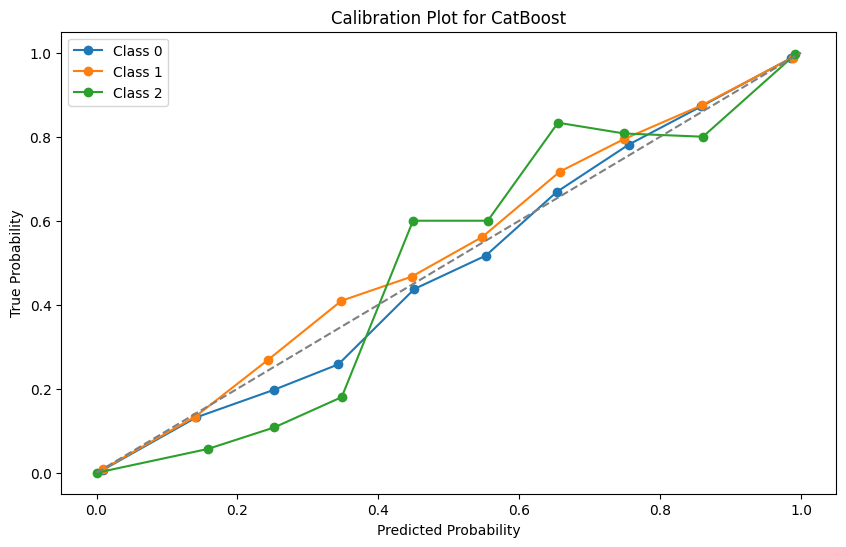

In [38]:
# کالیبراسیون
plt.figure(figsize=(10, 6))
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))
for i in range(n_classes):
    y_prob = cat_model.predict_proba(X_test_scaled)[:, i]
    y_prob = np.clip(y_prob, 0, 1)
    prob_true, prob_pred = calibration_curve(y_test_binarized[:, i], y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {i}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Plot for CatBoost')
plt.legend(loc="upper left")
plt.show()

# 1reg_ensembel

In [39]:
# آموزش مدل
# Combine predictions by averaging
ensemble_predictions = (rf_predictions + catboost_predictions) / 2


In [50]:
# پیش‌بینی
# Convert probabilities to binary predictions (threshold = 0.5)
ensemble_predictions_binary = (ensemble_predictions > 0.5).astype(int)

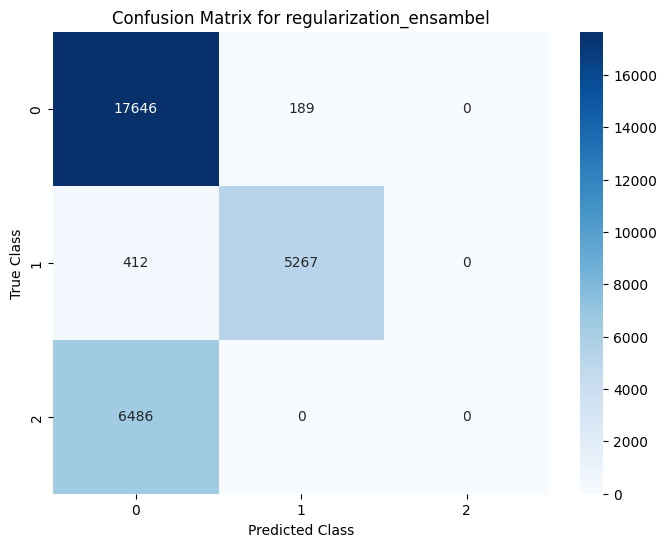

In [51]:
# ماتریس کانفیوژن
matrix_ensemble = confusion_matrix(y_test, ensemble_predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_ensemble , annot=True, cmap='Blues', fmt='g')
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix for regularization_ensambel")
plt.show()

In [52]:
# محاسبه متریک‌ها
accuracy_ensemble = accuracy_score(y_test, ensemble_predictions_binary)
f1_ensemble = f1_score(y_test, ensemble_predictions_binary, average='macro')
precision_ensemble = precision_score(y_test, ensemble_predictions_binary, average='macro')
recall_ensemble = recall_score(y_test, ensemble_predictions_binary, average='macro')
tn_ensemble = matrix_ensemble.sum() - matrix_ensemble.sum(axis=1) - matrix_ensemble.sum(axis=0) + np.diag(matrix_ensemble)
fp_ensemble = matrix_ensemble.sum(axis=0) - np.diag(matrix_ensemble)
specificity_ensemble = np.mean(tn_ensemble / (tn_ensemble + fp_ensemble))
tn_ensemble = matrix_ensemble.sum() - matrix_ensemble.sum(axis=1) - matrix_ensemble.sum(axis=0) + np.diag(matrix_ensemble)
fp_ensemble = matrix_ensemble.sum(axis=0) - np.diag(matrix_ensemble)
specificity_ensemble = np.mean(tn_ensemble / (tn_ensemble + fp_ensemble))


results.append({
        'Model':'Ensemble (RF + CatBoost)',
        'Accuracy':accuracy_ensemble,
        'f1-score': f1_ensemble,
        'Precision': precision_ensemble,
        'Sensitivity': recall_ensemble,
        'Specificity': specificity_ensemble
    })

print(f"Ensemble Model Accuracy: {accuracy_ensemble:.4f}")
print(f"F1-score: {f1_ensemble}")
print(f"Precision: {precision_ensemble}")
print(f"Recall (Sensitivity): {recall_ensemble}")
print(f"Specificity: {specificity_ensemble}")


Ensemble Model Accuracy: 0.7638
F1-score: 0.5929323306268385
Precision: 0.5614376511041356
Recall (Sensitivity): 0.638951625248624
Specificity: 0.8083974525337935


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


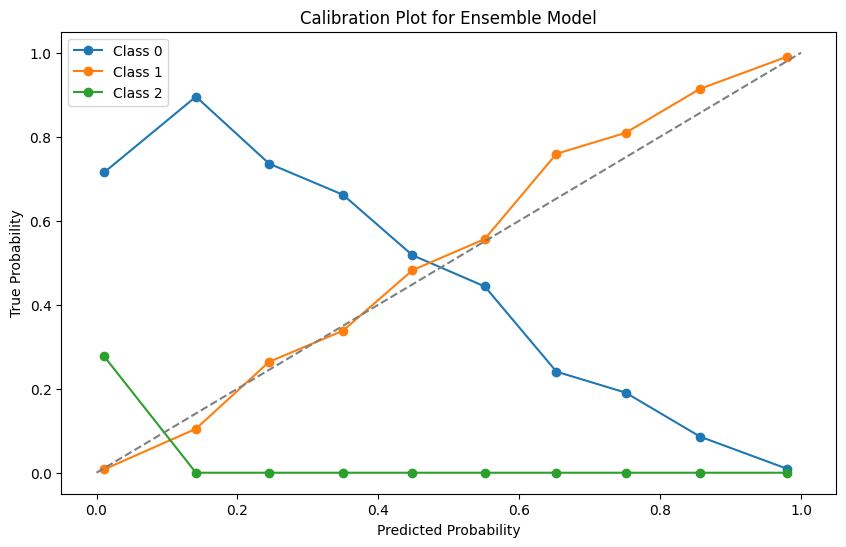

In [57]:
# کالیبراسیون برای مدل ترکیبی
plt.figure(figsize=(10, 6))
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

# چون به نظر می‌رسد که ensemble_predictions همیشه یک‌بعدی است، در هر حالتی از همین پیش‌بینی‌ها استفاده می‌کنیم
for i in range(n_classes):
    # در هر حالتی از احتمالات موجود در ensemble_predictions استفاده می‌کنیم
    y_prob = ensemble_predictions
    y_prob = np.clip(y_prob, 0, 1)
    prob_true, prob_pred = calibration_curve(y_test_binarized[:, i], y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class {i}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Plot for Ensemble Model')
plt.legend(loc="upper left")
plt.show()


# 2reg_CatBoost as feature Engineering

# 3reg_Hybrid Models

# 4reg_Bagging and Bossting combination

# 5reg_cross_validation and HyperParameter Tuning

# result

In [ ]:
results = []
# ذخیره نتایج در یک DataFrame و نمایش آن
results_df = pd.DataFrame(results)
#results_df.set_index('Model', inplace=True)
print(results_df)

           Model  Accuracy  f1-score  Precision  Sensitivity  Specificity
0  Decision Tree  0.962433  0.956523   0.955684     0.957378     0.977275
1  Random Forest  0.978100  0.974529   0.977622     0.971693     0.985484
2       catboost  0.977433  0.973694   0.978043     0.969647     0.984593
3        XGBoost  0.975967  0.972212   0.975526     0.969101     0.984032
4         voting  0.977933  0.974292   0.977662     0.971163     0.985259
5           LSTM  0.971567  0.967465   0.968815     0.966503     0.982200
6    transformer  0.968467  0.964373   0.961578     0.967380     0.981768


# ROC

124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


IndexError: index 2 is out of bounds for axis 1 with size 2

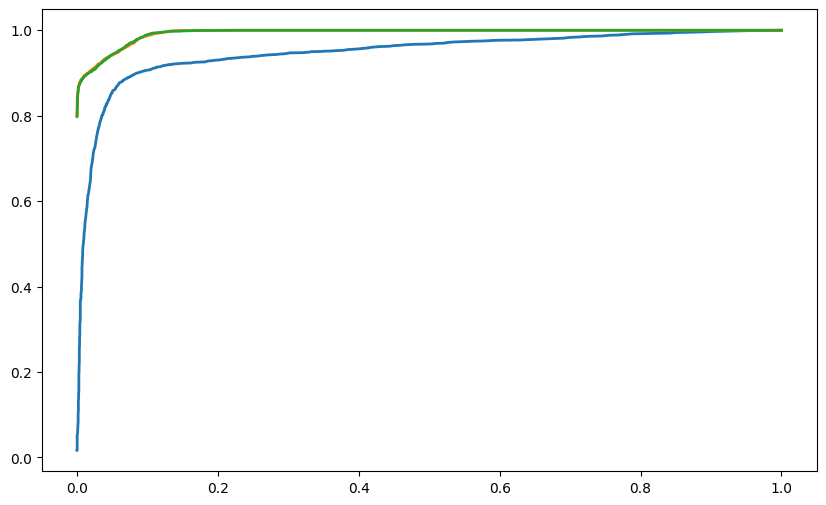

In [ ]:
models = {
    'Log Reg': logmodel,
    'XGBoost': xgb_model,
    'CatBoost': cat_model,
    'LSTM': lstm_clf,
    'Voting ': voting,
    'Des tree' : dt_model,
    'RF': rf_model

    #,'Voting Classifier without LSTM': votingwithoutlstm
}

# تنظیم اندازه شکل نمودار
plt.figure(figsize=(10, 6))

# تعداد کلاس‌ها
n_classes = y_score.shape[1]
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

# رسم منحنی ROC برای هر مدل
for model_name, model in models.items():
    if model_name == 'LSTM':
        y_score = model.predict(X_test_lstm)
    else:
        y_score = model.predict_proba(X_test_scaled)

    if y_score.ndim == 1:
        y_score = np.column_stack([1 - y_score, y_score])

    # محاسبه FPR، TPR و AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # محاسبه ROC ماکرو
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # رسم ROC ماکرو
    plt.plot(fpr["macro"], tpr["macro"], lw=2, label=f'{model_name} (AUC = {roc_auc["macro"]:.2f})')

# رسم خط مرجع
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# تنظیمات نهایی نمودار
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# نمایش نمودار
plt.show()
